In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter
from scipy.io import wavfile
from IPython.display import Audio

plt.rcParams.update({'font.size': 14})### final

说明：在“#在此处编写代码”处编写代码，待检查无误后，将验证代码部分去注释并运行，验证代码效果。

# 1. 认识函数

In [35]:
def minus(a, b):
    """
    返回两个数的和
    """
    res = a - b #在此处编写代码
    return res

#### 验证代码

In [36]:
#调用函数
result = minus(3, 4)
print(result) # 输出: 7

-1


# 2. 脉冲序列信号

In [37]:
def generate_source(duration, fs, f0=100):
    """
    生成单位脉冲序列信号
    :param  duration: 信号时长（秒）
    :param  fs: 采样率
    :param  f0: 基频（Hz）
    :return e: 周期脉冲序列
    """
    # 根据采样率和信号时长生成时间序列t
    t = np.arange(int(duration * fs)) / fs
    
    # 根据采样率和信号时长预定义输出信号的数组（元素全部为0）
    e = np.zeros(int(duration*fs))#在此处编写代码
    
    # 根据基频确定相邻脉冲的时间间隔
    T0 = int(1/f0 * fs) #在此处编写代码
    
    # 将相应位置置为1，生成单位脉冲序列,每T0个采样点置为1
    e[::T0] = 1 #在此处编写代码
    
    return t, e

#### 验证代码

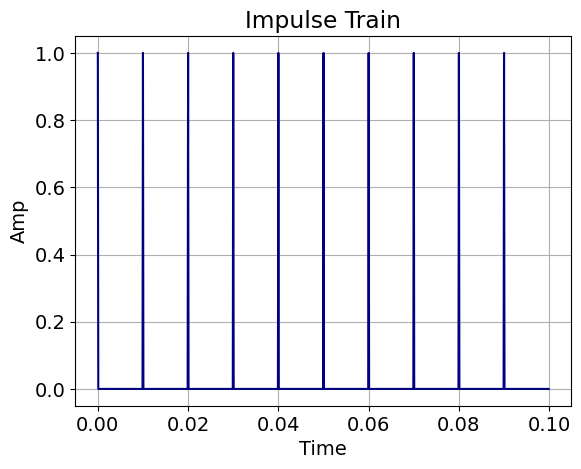

In [38]:
t, e = generate_source(0.1, 10000, f0=100)
fig, ax = plt.subplots()
ax.plot(t, e, 'navy')
ax.set_xlabel('Time')
ax.set_ylabel('Amp')
ax.set_title('Impulse Train')
plt.grid()
plt.show()

# 3. 声门脉冲

In [39]:
def glottal_pulse(N1=40, N2=10):
    """
    生成声门脉冲波形
    :param N1: 开相时长（样点数）
    :param N2: 闭相时长（样点数）
    :return: 归一化的声门脉冲波形
    """
    # 根据采样率和信号时长预定义输出信号的数组（元素全部为0）
    pulse = np.zeros(N1 + N2)
    
    # 计算开相阶段信号值
    pulse[:N1] = 0.5*(1 - np.cos( np.pi * np.arange(1,N1+1)/N1) ) #在此处编写代码
    
    # 计算闭相阶段信号值
    pulse[N1:] = np.cos(0.5 * np.pi * (np.arange(1,N2+1))/N2) #在此处编写代码

    # pulse除以pulse中的最大值
    pulse = pulse/np.max(pulse) #在此处编写代码
    return pulse

#### 验证代码

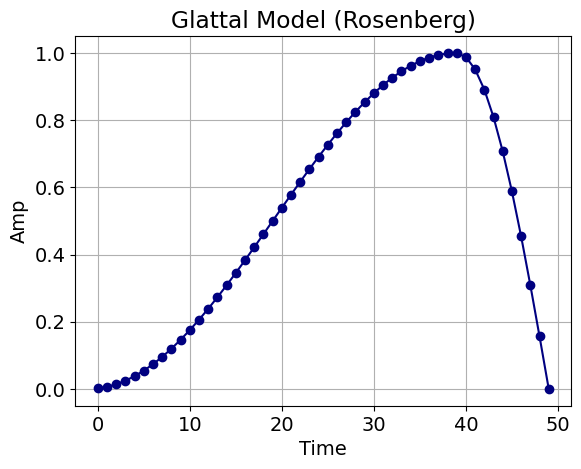

In [40]:
g = glottal_pulse(N1=40, N2=10)
fig, ax = plt.subplots()
ax.plot(g, 'navy', marker='o')
ax.set_xlabel('Time')
ax.set_ylabel('Amp')
ax.set_title('Glattal Model (Rosenberg)')
plt.grid()
plt.show()

# 4. 声道模型

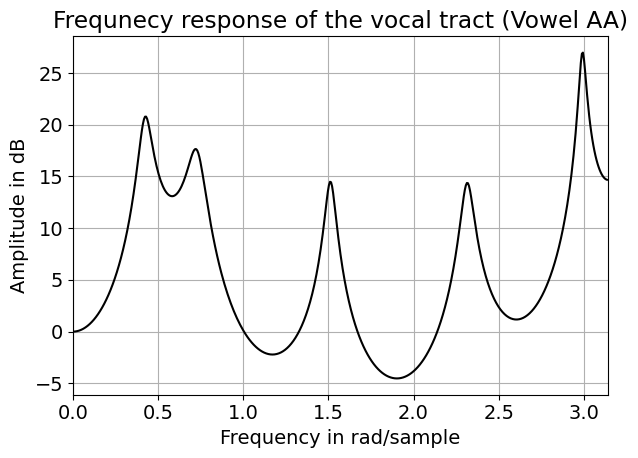

In [41]:
class VocalTractFilter:
    """
    声道模型滤波器
    :param b: 滤波器系数（分子）
    :param a: 滤波器系数（分母）
    :param gain: ；滤波器增益
    """
    def __init__(self, b, a, gain=1.0):
        self.b = b
        self.a = a
        self.gain = gain
        
    def process(self, signal):
        """
        滤波操作，将声门激励信号通过声道模型产生声道输出
        :param signal: 输入信号
        :return: 输出信号
        """
        return self.gain * lfilter(self.b, self.a, signal)

b = 1.9206
a = [1, -0.0460, -0.6232, 0.3814, 0.2443, 0.1973, 
     0.2873, 0.3655, -0.4806, -0.1153, 0.71]
vt_filter = VocalTractFilter(b=b,a=a,gain=1)

w, h = signal.freqz(b,a)
fig, ax = plt.subplots(tight_layout=True)
ax.plot(w, 20 * np.log10(abs(h)), 'k')
ax.set(xlabel="Frequency in rad/sample", xlim=(0, np.pi))
ax.set_ylabel("Amplitude in dB")
ax.set_title('Frequnecy response of the vocal tract (Vowel AA)')
plt.grid()
plt.show()

# 5. 唇齿辐射模型

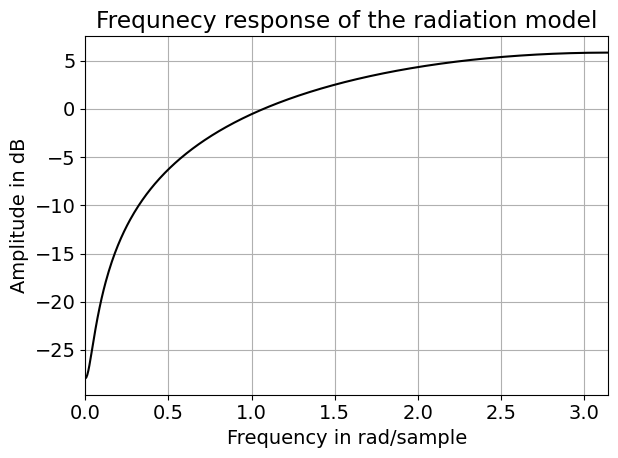

In [42]:
class RadiationFilter:
    """
    唇齿模型滤波器
    """
    def __init__(self, alpha=0.96):
        self.b = [1, -alpha]
        self.a = [1]
    
    def process(self, signal):
        return lfilter(self.b, self.a, signal)

b = [1, -0.96]
a = [1]
rf = RadiationFilter(alpha=0.96)
w, h = signal.freqz(b,a)
fig, ax = plt.subplots(tight_layout=True)
ax.plot(w, 20 * np.log10(abs(h)), 'k')
ax.set_ylabel("Amplitude in dB", color='k')
ax.set(xlabel="Frequency in rad/sample", xlim=(0, np.pi))
ax.set_title('Frequnecy response of the radiation model')
plt.tight_layout()
plt.grid()
plt.savefig('4.4.plot.png')
plt.show()

# 6. 应用声门模型

In [ ]:
def apply_glottal_model(e, pulse):
    return np.convolve(e, pulse, mode='same')

t, e = generate_source(0.6, 10000, f0=120)

g = glottal_pulse(N1=45, N2=15)

gp = apply_glottal_model(e, g)

vt_out = vt_filter.process(gp)

speech = rf.process(vt_out)

#### 验证代码

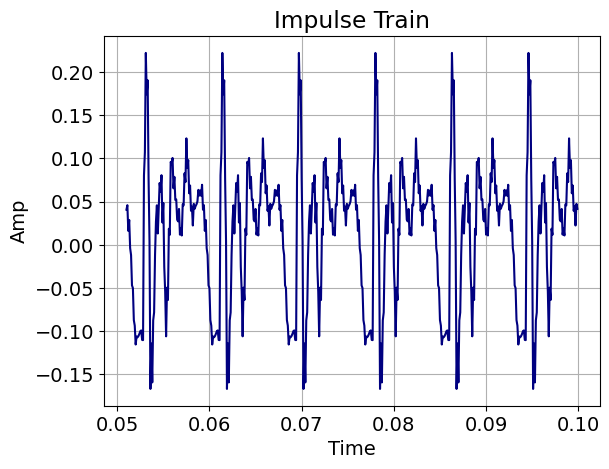

In [44]:
fig, ax = plt.subplots()
ax.plot(t[510:1000], speech[510:1000], 'navy')
ax.set_xlabel('Time')
ax.set_ylabel('Amp')
ax.set_title('Impulse Train')
plt.grid()
plt.show()

In [45]:
from scipy.io import wavfile

wavfile.write('vowel_aa.wav', 10000, (speech*32767).astype(np.int16))

In [46]:
from IPython.display import Audio

Audio('vowel_aa.wav')